## Imports

In [1]:
%load_ext autoreload

import warnings
warnings.filterwarnings("ignore")

import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 

import numpy as np
from oodeel.methods import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import *

from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import OODDataset
from oodeel.models.training_funs import train_convnet_classifier

model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## MNIST (0-4) vs MNIST (5-9)

### Data and model loading
ID data: MNIST (0-4), OOD data: MNIST (5-9)

In [3]:
oods_train = OODDataset('mnist', split="train")
oods_test = OODDataset('mnist', split="test")

batch_size = 128
inc_labels = [0, 1, 2, 3, 4]
oods_train, _ = oods_train.assign_ood_labels_by_class(in_labels=inc_labels)
oods_in, oods_out = oods_test.assign_ood_labels_by_class(in_labels=inc_labels)


def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

ds_train = oods_train.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)
ds_in = oods_in.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, with_ood_labels=False, preprocess_fn=preprocess_fn)

In [5]:

model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4/")

try:
    model = tf.keras.models.load_model(model_path_mnist_04)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "is_prepared": True,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(ds_train, **train_config) #ds_fit is actually the train set of MNIST

Epoch 1/5
    240/Unknown - 7s 21ms/step - loss: 0.2411 - accuracy: 0.9240

INFO:tensorflow:Assets written to: /Users/paul/.oodeel/saved_models/mnist_model_0-4/assets


INFO:tensorflow:Assets written to: /Users/paul/.oodeel/saved_models/mnist_model_0-4/assets


240/240 [==============================] - 10s 36ms/step - loss: 0.2411 - accuracy: 0.9240 - val_loss: 0.0373 - val_accuracy: 0.9877
Epoch 2/5
239/240 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9823

INFO:tensorflow:Assets written to: /Users/paul/.oodeel/saved_models/mnist_model_0-4/assets


INFO:tensorflow:Assets written to: /Users/paul/.oodeel/saved_models/mnist_model_0-4/assets


240/240 [==============================] - 8s 33ms/step - loss: 0.0582 - accuracy: 0.9823 - val_loss: 0.0231 - val_accuracy: 0.9930
Epoch 3/5
240/240 [==============================] - 6s 23ms/step - loss: 0.0458 - accuracy: 0.9866 - val_loss: 0.0215 - val_accuracy: 0.9930
Epoch 4/5
240/240 [==============================] - ETA: 0s - loss: 0.0429 - accuracy: 0.9872

INFO:tensorflow:Assets written to: /Users/paul/.oodeel/saved_models/mnist_model_0-4/assets


INFO:tensorflow:Assets written to: /Users/paul/.oodeel/saved_models/mnist_model_0-4/assets


240/240 [==============================] - 8s 32ms/step - loss: 0.0429 - accuracy: 0.9872 - val_loss: 0.0208 - val_accuracy: 0.9938
Epoch 5/5
240/240 [==============================] - 5s 22ms/step - loss: 0.0424 - accuracy: 0.9872 - val_loss: 0.0208 - val_accuracy: 0.9932


### DKNN score

auroc       0.967953
fpr95tpr    0.140494
Name: mnist-0-4-vs-5-10, dtype: float64


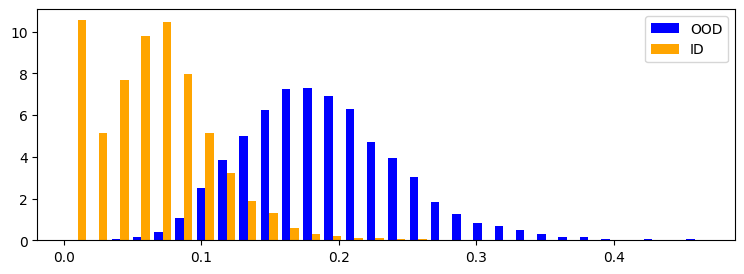

In [6]:
batch_size = 128

oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_train.take(10000))
scores_in = oodmodel.score(ds_in.take(1000))
scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr"], 
    )

metrics_first_vs_last = pd.Series(metrics, name='mnist-0-4-vs-5-10')
print(metrics_first_vs_last)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("OOD", "ID"), density=True)
plt.legend()
plt.show()

## MNIST vs Fashion MNIST


### Data and model loading
ID data: MNIST, OOD data: Fashion MNIST

In [7]:
oods_in = OODDataset('mnist', split="test")
oods_out = OODDataset('fashion_mnist', split="test")
oods_fit = OODDataset('mnist', split="train")

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))


batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)

In [8]:
model_path_mnist = os.path.join(model_path, "mnist_model")

try:
    model = tf.keras.models.load_model(model_path_mnist)
    
except OSError:
    train_config = {
        "input_shape": (28, 28, 1),
        "num_classes": 10,
        "batch_size": 128,
        "optimizer": "adam",
        "epochs": 5,
        "save_dir": model_path_mnist,
        "validation_data": oods_in.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_convnet_classifier(oods_fit.get_dataset(), **train_config) #

### DKNN score

auroc       0.99873
fpr95tpr    0.00530
Name: mnist-10-vs-fashion, dtype: float64


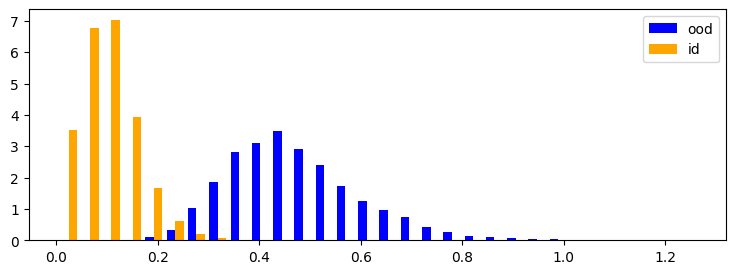

In [9]:
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_fit.take(10000))
scores_in = oodmodel.score(ds_in.take(1000))
scores_out = oodmodel.score(ds_out.take(1000))


metrics = bench_metrics(
    (scores_in, scores_out),  
    metrics = ["auroc", "fpr95tpr",], 
    )
metrics_fashion = pd.Series(metrics, name='mnist-10-vs-fashion')
print(metrics_fashion)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

## CIFAR-10 vs [SVHN, LSUN, iSUN, Texture]

### ID Data and model loading

In [11]:
%autoreload 2

oods_in = OODDataset('cifar10', split="test", input_key="image")
oods_fit = OODDataset('cifar10', split="train", input_key="image")

def preprocess_fn(*inputs):
    x = inputs[0] / 255
    return tuple([x] + list(inputs[1:]))

batch_size = 128
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_fit = oods_fit.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True)


In [10]:
from oodeel.models.training_funs import train_keras_app

model_path_cifar = os.path.join(model_path, "cifar10_adam")
try:
    model = tf.keras.models.load_model(model_path_cifar)
    
except OSError:
    train_config = {
        "input_shape": (32, 32, 3),
        "num_classes": 10,
        "batch_size": 128,
        "epochs": 60,
        "save_dir": model_path_cifar,
        "validation_data": oods_in.get_dataset() #ds_in is actually the test set of MNIST
    }

    model = train_keras_app(oods_fit.get_dataset(), "resnet18", **train_config) 

In [12]:
# ood dataset
oodmodel = DKNN(nearest=50, output_layers_id=["pool1"])
oodmodel.fit(model, ds_fit.take(100))
scores_in = oodmodel.score(ds_in.take(100))


### OOD data: SVHN
ID data: CIFAR-10, OOD data: SVHN

In [22]:

oods_out = OODDataset('svhn_cropped', split="test", input_key="image")
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

scores_out = oodmodel.score(ds_out.take(100))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_svhn = pd.Series(metrics, name='cifar-vs-svhn')
print(metrics_cifar_svhn)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

Loading tf.data.Dataset with elems as dicts, assigning "input_i" key to the i-th tuple dimension and "label" key to the last tuple dimension.


ValueError: Dimensions 32 and 26032 are not compatible

### OOD data: LSUN
ID data: CIFAR-10, OOD data: LSUN

In [23]:
import tensorflow as tf
import os
LSUN_root = os.path.join(data_path, "LSUN")
lsun_ds = tf.keras.utils.image_dataset_from_directory(
    LSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
# ood dataset
ds_out = OODDataset(lsun_ds).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out.take(100))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_lsun = pd.Series(metrics, name='cifar-vs-lsun')
print(metrics_cifar_lsun)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

NotFoundError: Could not find directory /Users/paul/datasets_oodeel/LSUN

### OOD data: iSUN
ID data: CIFAR-10, OOD data: iSUN

Found 8925 files belonging to 1 classes.
Feature name not found, assigning 'input_i' key to the i-th tensor and 'label' key to the last
auroc       0.893325
fpr95tpr    0.350400
Name: cifar-vs-isun, dtype: float64


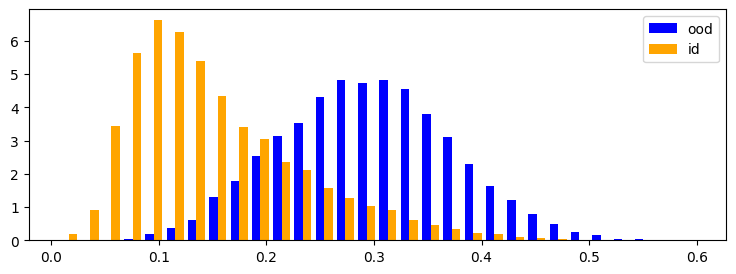

In [34]:
import tensorflow as tf
iSUN_root = os.path.join(data_path, "iSUN")
isun_ds = tf.keras.utils.image_dataset_from_directory(
    iSUN_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None
)
# ood dataset
x_ood = OODDataset(isun_ds).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_isun = pd.Series(metrics, name='cifar-vs-isun')
print(metrics_cifar_isun)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

### OOD data: Texture
ID data: CIFAR-10, OOD data: Texture

Found 5640 files belonging to 3 classes.
Feature name not found, assigning 'input_i' key to the i-th tensor and 'label' key to the last
auroc       0.893325
fpr95tpr    0.350400
Name: cifar-vs-texture, dtype: float64


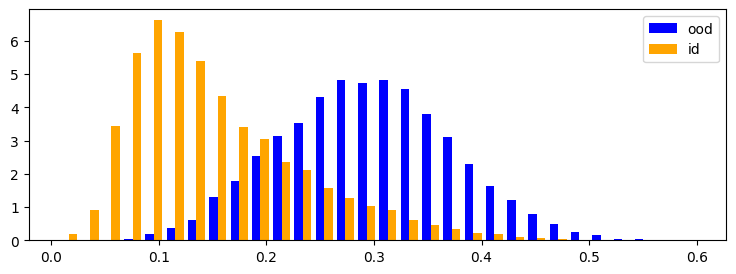

In [35]:
import tensorflow as tf
texture_root = os.path.join(data_path, "dtd")
texture_ds = tf.keras.utils.image_dataset_from_directory(
    texture_root,
    image_size=(32, 32),
    shuffle=False,
    batch_size=None,
)
# ood dataset
x_ood = OODDataset(texture_ds).prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
scores_out = oodmodel.score(ds_out.take(1000))

# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"]
)
metrics_cifar_texture = pd.Series(metrics, name='cifar-vs-texture')
print(metrics_cifar_texture)

# plot hists / roc
plt.figure(figsize=(9,3))
plt.hist((scores_out, scores_in), bins=30, color=("blue", "orange"), label=("ood", "id"), density=True)
plt.legend()
plt.show()

## Results

In [36]:
pd.concat([metrics_first_vs_last, metrics_fashion, metrics_cifar_svhn, metrics_cifar_lsun, metrics_cifar_isun, metrics_cifar_texture], axis=1).T

NameError: name 'metrics_first_vs_last' is not defined